In [ ]:
# CÉLULA 1 — COLETA & FILTRO DAS IMAGENS
%pip install bing-image-downloader
import os
from bing_image_downloader import downloader
from concurrent.futures import ThreadPoolExecutor, as_completed

# Função de download individual
def baixar(keyword, limit, output_dir):
    print(f"Iniciando download: {keyword}")
    downloader.download(
        keyword,
        limit=limit,
        output_dir=output_dir,
        adult_filter_off=True,
        force_replace=False,
        timeout=60  # deixei maior pra evitar timeouts bestas
    )
    print(f"Finalizou: {keyword}")

# Lista de tarefas
tasks = [
    ("Batman", 200, 'dataset'),
    ("city street", 100, 'dataset'),
    ("forest", 100, 'dataset'),
    ("cats", 100, 'dataset'),
    ("dogs", 100, 'dataset'),
    ("dinosaurs", 100, 'dataset'),
    ("people smiling", 100, 'dataset'),
    ("Darth Vader", 100, 'dataset'),
    ("Marvel", 100, 'dataset'),
    ("Black Panther Hero", 100, 'dataset')
]

# Executor paralelizando com até 5 threads
with ThreadPoolExecutor(max_workers=5) as executor:
    future_to_task = {executor.submit(baixar, *t): t[0] for t in tasks}
    for future in as_completed(future_to_task):
        keyword = future_to_task[future]
        try:
            future.result()
        except Exception as e:
            print(f"Erro no download de {keyword}: {e}")

# Limpa para manter apenas jpg, jpeg e png
def clean_initial_downloads(path):
    allowed_exts = ('.jpg', '.jpeg', '.png')
    for root, dirs, files in os.walk(path):
        for file in files:
            if not file.lower().endswith(allowed_exts):
                os.remove(os.path.join(root, file))
                print(f"Removendo {file}")

clean_initial_downloads("dataset")



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: c:\Users\kevin\.pyenv\pyenv-win\versions\3.12.2\python.exe -m pip install --upgrade pip



Iniciando download: Batman
[%] Downloading Images to e:\ProjetosCV\isbatman\dataset\Batman


[!!]Indexing page: 1

Iniciando download: city street
Iniciando download: forest
Iniciando download: cats
Iniciando download: dogs
[%] Downloading Images to e:\ProjetosCV\isbatman\dataset\city street


[!!]Indexing page: 1

[%] Downloading Images to e:\ProjetosCV\isbatman\dataset\dogs


[!!]Indexing page: 1

[%] Downloading Images to e:\ProjetosCV\isbatman\dataset\forest


[!!]Indexing page: 1

[%] Downloading Images to e:\ProjetosCV\isbatman\dataset\cats


[!!]Indexing page: 1

[%] Indexed 95 Images on Page 1.


[%] Downloading Image #1 from https://commonslibrary.parliament.uk/content/uploads/2018/02/The_City_London-scaled.jpg
[%] Indexed 95 Images on Page 1.


[%] Downloading Image #1 from https://1.bp.blogspot.com/-9Ys6kScXgf0/W6yApNSb5aI/AAAAAAAABWM/podw57hgXvsVY-JYl7sThU34NT-IcMz-ACLcBGAs/s1600/batman%2Bwallpaper.jpg
[%] Indexed 95 Images on Page 1.


[%] Downloading Image #1 from https:

In [1]:
# CÉLULA 2 — RENOMEIA TUDO QUE NÃO É BATMAN PARA PREFIXO notbatman

import uuid
import os

# Lista de todas as pastas não Batman
not_batman_folders = [
    'dataset/Marvel',
    'dataset/Black Panther Hero',
    'dataset/Darth Vader',
    'dataset/people smiling',
    'dataset/cats',
    'dataset/dogs',
    'dataset/dinosaurs',
    'dataset/forest',
    'dataset/city street'
]

def rename_files(folder_path, prefix):
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                old_path = os.path.join(root, file)
                new_name = f"{prefix}_{uuid.uuid4().hex}.jpg"
                new_path = os.path.join(root, new_name)
                os.rename(old_path, new_path)

for folder in not_batman_folders:
    if os.path.exists(folder):
        rename_files(folder, "notbatman")
    else:
        print(f"Pasta não encontrada e ignorada: {folder}")


In [2]:
# CÉLULA 3 — MOVE TODOS ARQUIVOS PARA dataset/not_batman

import shutil

# Cria pasta final
os.makedirs('dataset/not_batman', exist_ok=True)

def move_all_images(src_folder, dest_folder):
    for root, _, files in os.walk(src_folder):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                src_path = os.path.join(root, file)
                dst_path = os.path.join(dest_folder, file)
                shutil.move(src_path, dst_path)

for folder in not_batman_folders:
    if os.path.exists(folder):
        move_all_images(folder, 'dataset/not_batman')
    else:
        print(f"Pasta não encontrada e ignorada: {folder}")

# Agora remove todas as pastas que não sejam Batman ou not_batman
for folder in os.listdir('dataset'):
    folder_path = os.path.join('dataset', folder)
    if os.path.isdir(folder_path) and folder not in {'Batman', 'not_batman'}:
        shutil.rmtree(folder_path)
        print(f"Pasta removida: {folder_path}")


Pasta removida: dataset\Black Panther Hero
Pasta removida: dataset\cats
Pasta removida: dataset\city street
Pasta removida: dataset\Darth Vader
Pasta removida: dataset\dinosaurs
Pasta removida: dataset\dogs
Pasta removida: dataset\forest
Pasta removida: dataset\Marvel
Pasta removida: dataset\people smiling


In [6]:
from PIL import Image
import numpy as np
import tensorflow as tf
import os

def validate_images_hardcore(path):
    count_total = 0
    count_removed = 0
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                count_total += 1
                file_path = os.path.join(root, file)
                try:
                    # 1. Verifica header com Pillow
                    with Image.open(file_path) as img:
                        img.verify()

                    # 2. Reabre, força decompressão e garante RGB
                    with Image.open(file_path).convert('RGB') as img:
                        arr = np.array(img)
                        if arr.ndim != 3 or arr.shape[2] != 3:
                            raise ValueError(f"Imagem não é RGB válida, shape: {arr.shape}")
                    
                    # 3. Valida com TensorFlow (decode_image que vai ser usado no pipeline)
                    img_data = tf.io.read_file(file_path)
                    tf.io.decode_image(img_data, channels=3)

                except Exception as e:
                    print(f"Removendo inválida: {file_path} | Motivo: {e}")
                    os.remove(file_path)
                    count_removed += 1

    print(f"Total verificadas: {count_total}, removidas: {count_removed}")

validate_images_hardcore("dataset")


Removendo inválida: dataset\Batman\Image_111.jpg | Motivo: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Removendo inválida: dataset\Batman\Image_127.jpeg | Motivo: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Removendo inválida: dataset\Batman\Image_67.jpg | Motivo: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Removendo inválida: dataset\Batman\Image_70.jpg | Motivo: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 


c:\Users\kevin\.pyenv\pyenv-win\versions\3.12.2\Lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Removendo inválida: dataset\not_batman\notbatman_016ef457d24b4f8d87c48c79578b90c2.jpg | Motivo: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Removendo inválida: dataset\not_batman\notbatman_04fe502bda254fd1b9bc5ce4bbf62cb3.jpg | Motivo: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 


c:\Users\kevin\.pyenv\pyenv-win\versions\3.12.2\Lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


Removendo inválida: dataset\not_batman\notbatman_45425ad371cf4c478da710fda845247d.jpg | Motivo: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Removendo inválida: dataset\not_batman\notbatman_5a6850c8b1c74056ad4138ed83a69d7c.jpg | Motivo: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 


c:\Users\kevin\.pyenv\pyenv-win\versions\3.12.2\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Removendo inválida: dataset\not_batman\notbatman_6877d3659a2d4c5a975d22499fe8d1d9.jpg | Motivo: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Removendo inválida: dataset\not_batman\notbatman_7fecd58b91754e17a11a27f4a422b03a.jpg | Motivo: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Removendo inválida: dataset\not_batman\notbatman_8ea926fc4103428b874d11a9dfc4c27e.jpg | Motivo: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Removendo inválida: dataset\not_batman\notbatman_8f93375336674eafa81f28fd1bdd114a.jpg | Motivo: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/ta

In [7]:
# Célula 5: DATASET & AUGMENTATION
%pip install tensorflow
import tensorflow as tf

batch_size = 32
img_height = 224
img_width = 224

# Cria datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary'
)

# Pipeline de augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
])

AUTOTUNE = tf.data.AUTOTUNE

# Aplica augmentation só no treino
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

# Pré-carrega batches
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

print("Datasets carregados e augmentation configurado.")


Note: you may need to restart the kernel to use updated packages.
Found 1047 files belonging to 2 classes.
Using 838 files for training.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: c:\Users\kevin\.pyenv\pyenv-win\versions\3.12.2\python.exe -m pip install --upgrade pip


Found 1047 files belonging to 2 classes.
Using 209 files for validation.
Datasets carregados e augmentation configurado.


In [8]:
# Célula 6: MODELO
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [9]:
# Célula 7: TREINAMENTO
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.6627 - loss: 0.6559 - val_accuracy: 0.8038 - val_loss: 0.4520
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.8388 - loss: 0.3839 - val_accuracy: 0.8182 - val_loss: 0.3908
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - accuracy: 0.8615 - loss: 0.3308 - val_accuracy: 0.8325 - val_loss: 0.3590
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.8753 - loss: 0.2953 - val_accuracy: 0.8278 - val_loss: 0.3462
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.8770 - loss: 0.2763 - val_accuracy: 0.8325 - val_loss: 0.3356
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.8878 - loss: 0.2612 - val_accuracy: 0.8469 - val_loss: 0.3248
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.9062 - loss: 0.2377 - val_accuracy: 0.8421 - val_loss: 0.3189
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8954 - loss: 0.2453 - val_accuracy: 0.8708 - val_lo


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: c:\Users\kevin\.pyenv\pyenv-win\versions\3.12.2\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


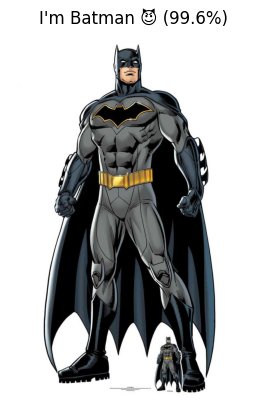

In [12]:
# Célula 8: TESTE COM LINK DE IMAGEM
%pip install matplotlib
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

# Ajuste o link direto da imagem
url = "http://cdn11.bigcommerce.com/s-ydriczk/images/stencil/1500x1500/products/89093/93728/DC-Comics-Batman-Caped-Crusader-official-cardboard-cutout-buy-now-at-starstills__04189.1582849820.jpg?c=2&imbypass=on"

response = requests.get(url)
if "image" not in response.headers["Content-Type"]:
    raise ValueError("Esse link não parece ser de imagem. Use um link direto (.jpg, .png)")

img = Image.open(BytesIO(response.content)).convert('RGB')
os.makedirs("testebatman", exist_ok=True)
img_path = os.path.join("testebatman", "img_teste.jpg")
img.save(img_path)

# Prepara para o modelo
img_resized = img.resize((img_height, img_width))
img_array = np.array(img_resized) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predição
pred = model.predict(img_array)[0][0]
percent = pred * 100

# Mostra imagem e resultado
plt.imshow(img)
plt.axis('off')
if pred > 0.45:
    plt.title(f"I'm Batman 😈 ({percent:.1f}%)")
else:
    plt.title(f"🤡 hahahahhahaa Achou que era o morcegão? ({percent:.1f}%)")
plt.show()
